<a href="https://colab.research.google.com/github/nannahyo/test/blob/main/StyleCLIP_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Install CLIP
가장 먼저 CLIP 라이브러리를 설치한다. CLIP은 image Encoder와 text Encoder를 포함하고 있는 네트워크로, 특정한 이미지와 특정한 문장이 서로 얼마나 닮아 있는지, 그 similarity를 구할 수 있도록 해준다. 
코드 실행시 경고 메시지가 나올 경우, ‘무시하고 계속하기’를 누르고 기다린다.
설치가 완료되면, 한번 더 실행해서 'Requirement already satisfied’ 메시지를 확인한다.

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-xy0gpako
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-xy0gpako


2. Load the Pre-trained StyleGAN Mode
사전 학습된 SylteGAN Model을 로드한다. SylteGAN은 고해상도의 이미지를 생성하기에 적합한 architecture이다. 본 논문에서는 기본 method로 Syle Gal verson 2 model을 사용하기 때문에, 이 모델을 다운로드 받아 실행할 수 있도록 한다.

In [ ]:
!git clone https://github.com/nannahyo/test
%cd test

Cloning into 'test'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 277 (delta 3), reused 21 (delta 2), pack-reused 253
Receiving objects: 100% (277/277), 57.09 MiB | 17.19 MiB/s, done.
Resolving deltas: 100% (97/97), done.
/content/test


In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1 -O stylegan2-ffhq-config-f.pt

--2022-11-08 01:11:39--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt?ga=1 [following]
--2022-11-08 01:11:40--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 381462551 (364M) [application/octet-stream]
Saving to: ‘stylegan2-ffhq-config-f.pt’

stylegan2-ffhq-conf 100%[===================>] 363.79M  78.4MB/s    in 5.2s    

2022-11-08 01:11:45 (69.7

3. 위의 작업을 통해 모델 가중치 파일이 모두 다운로도 완료되었으면, 생성자 모델을 초기화한다.

In [ ]:
import torch
from stylegan2.model import Generator


g_ema = Generator(1024, 512, 8)
g_ema.load_state_dict(torch.load('stylegan2-ffhq-config-f.pt')["g_ema"], strict=False)
g_ema.eval()
g_ema = g_ema.cuda()

4. CLIP Loss
CLIP Loss함수를 정의한다. CLIP Loss는 하나의 이미지와 텍스트를 입력으로 받아 그 이미지와 텍스트의 similarity를 return하는 방식으로 구현되었다.

In [ ]:
import clip


class CLIPLoss(torch.nn.Module):

    def __init__(self):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("ViT-B/32", device="cuda")
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=32)

    def forward(self, image, text):
        image = self.avg_pool(self.upsample(image))
        similarity = 1 - self.model(image, text)[0] / 100
        return similarity

5. Latent Optimization
기본 설명 : Latent Optimization은 CLIP 네트워크에 포함되어있는 Text Encoder와 image Encoder, StyleGAN을이용해서 image manipulation을 진행한다. 즉 Latent vector w를 업데이트하되, Latent vector w로 만들어진 이미지의 그 inbuilding이 특정한 text prompt와 similarity가 높아질 수 있는 방향으로 Latent vector를 업데이트하는 것이다. 일반적으로 latent vector를 만들 때에는 특정한 이미지에서부터 인코딩을 하거나 랜덤 샘플링을 이용해 latent vector를 만들 수 있다. 여기서는 랜덤 latent vector를 사용한다.
‘mean_latent’는 평균치의 값을 갖고있는 latent를 의미한다. 이때 truncation 트릭을 이용해서 보다 realistic한 이미지를 만들어낼 수 있다. truncation은 특정한 latent vector가 mean_latent로부터 크게 벗어나지 않도록 latent를 잘라내주는 역할을 수행하는 트릭이다. 아래 코드에서처럼, 0.7정도의 값을 넣었을 때(truncation=0.7) 그럴싸한 랜덤 이미지가 만들어지는 경향이 있다.
StyleCLIP의 가장 기본적인 방법은 Optimization method이다. 
CLIP Loss가 핵심이다. Latent vector w를 원본 이미지와 유사하게 업테이트를 하는 동시에, 특정한 texp prompt와 생성된 이미지가 유사한 similarity를 갖도록 같이 업데이트하는 것이다.
* 우리가 사용하고 있는 사전 학습된 StyleGAN 모델은 1024*1024의 고해상도 이미지를 만들어내기때문에 아래의 코드(image.resize((h // 2, w // 2)))처럼 너비와 높이를 2배씩 줄여서 화면에 간단히 출력될 수 있도록 하였다.


- 아래 코드 : a random latent vector를 a mean latent vector를 이용해 초기화하고 시각화하기

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


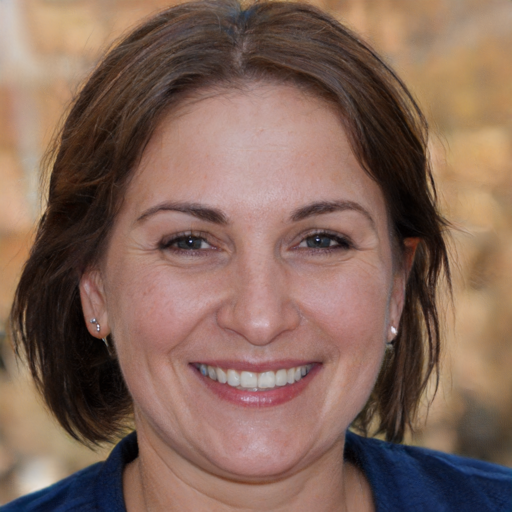

In [ ]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage


mean_latent = g_ema.mean_latent(4096)

latent_code_init_not_trunc = torch.randn(1, 512).cuda()
with torch.no_grad():
    img_orig, latent_code_init = g_ema([latent_code_init_not_trunc], return_latents=True,
                                truncation=0.7, truncation_latent=mean_latent)

# Visualize a random latent vector.
image = ToPILImage()(make_grid(img_orig.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = image.size
image.resize((h // 2, w // 2))

- 코드 구현을 위한 parameter set하기
아래의 코드에서 description은 text prompt이다.
l2_lamda는 가중치 parameter(λ_L2)이다. λ_L2가 커질수록 원본 이미지와 유사해지려는 힘이 강해지고, λ_L2가 작다면 특정한 text prompt와 높은 similarity를 갖게 될 것이다.

In [ ]:
from argparse import Namespace


args = Namespace()
args.description = 'A really sad face'
args.lr_rampup = 0.05
args.lr = 0.1
args.step = 150
args.l2_lambda = 0.005 # The weight for similarity to the original image.
args.save_intermediate_image_every = 1
args.results_dir = 'results'

- latent vector를 optimize하고 결과 얻기
기본적으로 StyleCLIP은 learning rate을 각 스텝마다 적절히 조정해서 적용할 수 있도록 하는learning rate adjustment function을 사용한다. 즉, 고정된 특정 learning rate만 사용하는 것이 아니라 스텝이 반복되는 과정에서 learning rate을 적절히 조정해서 optimization을 보다 매끄럽게 수행할 수 있도록 하는 것이다.
위에서 입력한 description ‘A really sad face’는 먼저 tokenize 된 이후에, 실제 clip encoder에 들어갈 수 있다.
Adam optimizer를 사용해서 latent vector를 업데이트할 수 있도록한다.
각각의 스텝마다 아래의 코드내용이 반복적으로 수행된다.
먼저 learning rate을 조정한다.
latent vector를 이용해서 image를 생성한다.
그렇게 생성된 image와 우리가 입력한 text prompt가 유사한 similarity를 갖도록 업데이트를 해준다.(c_loss)
그와 동시에 초기 latent vector와 유사한 형태를 가지도록 latent vector를 제안하는 loss를 넣어준다.(l2_loss)
이러한 두가지 loss를 이용해서 latent vector를 optimization한다.
이러한 loss를 기반으로 backpromptgation한 뒤에, gradient를 구한다.
그렇게 구한 gradient를 이용하여 latent vector를 업데이트한다.
이 코드 전체를 실행하는데에 약 2~3분 정도의 시간이 소요된다.

In [ ]:
import os
import math
import torchvision
from torch import optim


# The learning rate adjustment function.
def get_lr(t, initial_lr, rampdown=0.50, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp


text_inputs = torch.cat([clip.tokenize(args.description)]).cuda()
os.makedirs(args.results_dir, exist_ok=True)

# Initialize the latent vector to be updated.
latent = latent_code_init.detach().clone()
latent.requires_grad = True

clip_loss = CLIPLoss()
optimizer = optim.Adam([latent], lr=args.lr)

for i in range(args.step):
    # Adjust the learning rate.
    t = i / args.step
    lr = get_lr(t, args.lr)
    optimizer.param_groups[0]["lr"] = lr

    # Generate an image using the latent vector.
    img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)

    # Calculate the loss value.
    c_loss = clip_loss(img_gen, text_inputs)
    l2_loss = ((latent_code_init - latent) ** 2).sum()
    loss = c_loss + args.l2_lambda * l2_loss

    # Get gradient and update the latent vector.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log the current state.
    print(f"lr: {lr}, loss: {loss.item():.4f}")
    if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
        with torch.no_grad():
            img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)
        torchvision.utils.save_image(img_gen, f"results/{str(i).zfill(5)}.png", normalize=True, range=(-1, 1))

with torch.no_grad():
    img_orig, _ = g_ema([latent_code_init], input_is_latent=True, randomize_noise=False)

# Display the initial image and result image.
final_result = torch.cat([img_orig, img_gen])
torchvision.utils.save_image(final_result.detach().cpu(), os.path.join(args.results_dir, "final_result.jpg"), normalize=True, scale_each=True, range=(-1, 1))

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 95.6MiB/s]


lr: 0.0, loss: 0.8145
lr: 0.013333333333333334, loss: 0.8145
lr: 0.02666666666666667, loss: 0.8081
lr: 0.04, loss: 0.8140
lr: 0.05333333333333334, loss: 0.8262
lr: 0.06666666666666667, loss: 0.8438
lr: 0.08, loss: 0.8428
lr: 0.09333333333333334, loss: 0.8374
lr: 0.1, loss: 0.8701
lr: 0.1, loss: 0.8828
lr: 0.1, loss: 0.8774
lr: 0.1, loss: 0.8623
lr: 0.1, loss: 0.8623
lr: 0.1, loss: 0.8496
lr: 0.1, loss: 0.8584
lr: 0.1, loss: 0.8564
lr: 0.1, loss: 0.8462
lr: 0.1, loss: 0.8311
lr: 0.1, loss: 0.8218
lr: 0.1, loss: 0.8159
lr: 0.1, loss: 0.8091
lr: 0.1, loss: 0.8169
lr: 0.1, loss: 0.8193
lr: 0.1, loss: 0.8145
lr: 0.1, loss: 0.8140
lr: 0.1, loss: 0.8003
lr: 0.1, loss: 0.7891
lr: 0.1, loss: 0.7983
lr: 0.1, loss: 0.7959
lr: 0.1, loss: 0.8022
lr: 0.1, loss: 0.8008
lr: 0.1, loss: 0.7935
lr: 0.1, loss: 0.7900
lr: 0.1, loss: 0.7856
lr: 0.1, loss: 0.7827
lr: 0.1, loss: 0.7754
lr: 0.1, loss: 0.7773
lr: 0.1, loss: 0.7827
lr: 0.1, loss: 0.7847
lr: 0.1, loss: 0.7886
lr: 0.1, loss: 0.8071
lr: 0.1, loss: 

6, 결과 시각화하기
최적화 결과, 조금 슬픈 표정을 짓는 얼굴을 확인할 수 있다.

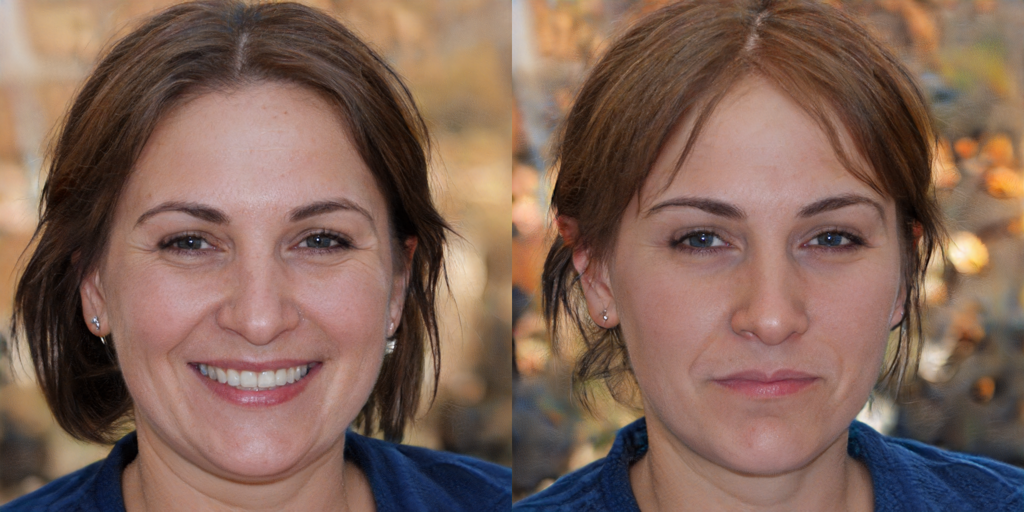

In [ ]:
result_image = ToPILImage()(make_grid(final_result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

7. amination video 생성하고 다운로드받기
 이미지가 서서히 변화하는 과정을 담은 비디오를 다운로드 받을 수 있다. 총 150번의 스텝을 반복했기 때문에 150 프레임으로 구성된 동영상을 생성하여 다운로드할 수 있다. 다운로드는 코드를 실행하면 자동으로 된다. 보고서에 작성된 이미지에 대한 비디오는 Github에 ‘out video’으로 올라가있다.

In [ ]:
!ffmpeg -r 15 -i results/%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4

from google.colab import files
files.download('out.mp4')

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>